In [1]:
!nvidia-smi

Wed Jun 24 00:23:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:60:00.0 Off |                  N/A |
|  0%   58C    P0    78W / 250W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as utils
import imageio
import warnings
import numpy as np
import astropy.stats as st
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import collections as col
import torchvision.models as models

In [3]:
sns.set_style('white')
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = (8, 5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def get_n_params(model):
    trainable = filter(lambda x: x.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in trainable])
    return n_params

In [5]:
def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm ** (0.5)

In [6]:
class SSTPatchDataset(torch.utils.data.Dataset):
    def __init__(self, filepath, partition, standardize=True, mu=None, stdv=None):
        self.standardize = standardize

        print("Creating dataset from file:", filepath)
        fields = np.load(filepath)[f'{partition.lower()}_fields'].astype(np.float32)
        metadata = np.load(filepath, allow_pickle=True)[f'{partition.lower()}_meta']
        
        if standardize:
            if not mu:
                mu = fields.mean()
            if not stdv:
                stdv = fields.std()
            fields = (fields - mu) / stdv
        
        self.mu = mu
        self.stdv = stdv
        self.fields = torch.from_numpy(fields)
        self.metadata = metadata
        print(f"Data shape: {fields.shape}")
    
    def inverse_transform(self, x):
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        if self.standardize:
            x = x * self.stdv + self.mu
        return x
        
    def __getitem__(self, i):
        field = self.fields[i][None, :, :]
        meta = self.metadata[i].tolist()
        return field, meta
    
    def __len__(self):
        return self.fields.size(0)

In [7]:
class Bottleneck(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, inplanes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += residual
        out = self.relu(out)

        return out

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self, in_features, out_features, n_blocks):
        super().__init__()
        self.conv = nn.Conv2d(
            in_features, out_features, kernel_size=3, 
            stride=2, padding=1, bias=False)
        self.act = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_features)
        self.blocks = nn.ModuleList([
            Bottleneck(out_features, out_features // 4) 
            for _ in range(n_blocks)])
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(self.act(x))
        for b in self.blocks:
            x = b(x)
        return x

In [9]:
class DecoderLayer(nn.Module):
    def __init__(self, in_features, out_features,
                n_blocks, scale_factor=2, pad=4):
        super().__init__()
        self.scale_factor = scale_factor
        self.pad = pad
        self.conv = nn.Conv2d(
            in_features, out_features, kernel_size=3, 
            stride=1, padding=1, bias=False)
        self.act = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_features)
        self.blocks = nn.ModuleList([
            Bottleneck(in_features, in_features * 4) 
            for _ in range(n_blocks)])
    
    def forward(self, x):
        for b in self.blocks:
            x = b(x)
        x = F.pad(x, (self.pad, self.pad, self.pad, self.pad))
        x = F.interpolate(x, scale_factor=self.scale_factor)
        idx = self.pad * self.scale_factor
        x = x[:, :, idx:-idx, idx:-idx]
        x = self.conv(x)
        x = self.bn(self.act(x))
        return x

In [23]:
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=256, blocks_per_layer=0):
        super().__init__()
    
        self.encoder = nn.ModuleList([
            EncoderLayer(1, 32, blocks_per_layer),
            EncoderLayer(32, 64, blocks_per_layer),
            EncoderLayer(64, 128, blocks_per_layer),
            EncoderLayer(128, 256, blocks_per_layer),
            EncoderLayer(256, 512, blocks_per_layer)])
        self.e_to_z = nn.Linear(3*3*512, latent_dim)
        self.z_to_d = nn.Linear(latent_dim, 3*3*512)
        self.decoder = nn.ModuleList([
            DecoderLayer(512, 256, blocks_per_layer),
            DecoderLayer(256, 128, blocks_per_layer),
            DecoderLayer(128, 64, blocks_per_layer),
            DecoderLayer(64, 32, blocks_per_layer),
            DecoderLayer(32, 32, blocks_per_layer)])
        self.out = nn.Conv2d(32, 1, 1, 1)
    
    def _forward(self, x):
        bsz = x.size(0)
        for layer in self.encoder:
            x = layer(x)
        z = self.e_to_z(x.view(bsz, -1))
        x = self.z_to_d(z).view(bsz, 512, 3, 3)
        for layer in self.decoder:
            x = layer(x)
        x = self.out(x)
        return x, z
    
    def forward(self, x):
        rx, _ = self._forward(x)
        loss = F.mse_loss(x, rx)
        return loss

In [11]:
train_dset = SSTPatchDataset('./data/processed/MODIS_night_data_no_mask.npz', 'train')
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=64, drop_last=True, shuffle=True, num_workers=8)
valid_dset = SSTPatchDataset('./data/processed/MODIS_night_data_no_mask.npz', 'valid', mu=train_dset.mu, stdv=train_dset.stdv)
valid_loader = torch.utils.data.DataLoader(valid_dset, batch_size=64, drop_last=True, shuffle=False, num_workers=8)

Creating dataset from file: ./data/processed/MODIS_night_data_no_mask.npz
Data shape: (53384, 96, 96)
Creating dataset from file: ./data/processed/MODIS_night_data_no_mask.npz
Data shape: (5000, 96, 96)


In [12]:
field, meta = next(iter(train_loader))

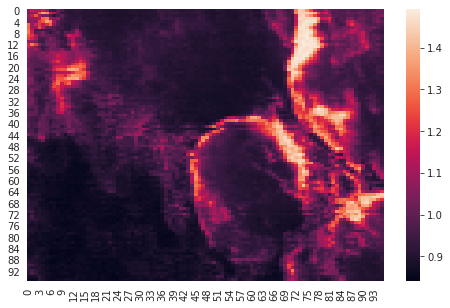

In [13]:
idx = np.random.choice(field.size(0))
f = field[idx, 0].detach().cpu().numpy()
sns.heatmap(f)

In [24]:
model = AutoEncoder(256, 0).to(device)
print(f"There are {get_n_params(model):,d} parameters in this model.")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

There are 5,510,145 parameters in this model.


In [20]:
# vgg16 = models.vgg16(pretrained=True)

In [25]:
model

AutoEncoder(
  (encoder): ModuleList(
    (0): EncoderLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (act): ReLU()
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (blocks): ModuleList()
    )
    (1): EncoderLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (act): ReLU()
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (blocks): ModuleList()
    )
    (2): EncoderLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (act): ReLU()
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (blocks): ModuleList()
    )
    (3): EncoderLayer(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (act): ReLU()
      (bn): BatchNorm2d(256, eps=1e-05

In [26]:
model(field.to(device))

tensor(1.3841, device='cuda:0', grad_fn=<MeanBackward0>)

In [27]:
global_step = 0
n_epochs = 200
summary_interval = 50
eval_interval = 500
best_val_loss = np.inf
best_recon_loss = np.inf
metrics = col.defaultdict(list)

In [28]:
try:
    total_loss = 0
    for epoch in range(n_epochs):
        for field, meta in train_loader:
            optimizer.zero_grad()
            loss = model(field.to(device))
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            global_step += 1
        
            if global_step % summary_interval == 0:
                current_loss = float(total_loss) / summary_interval
                print(f"Loss: {current_loss:.5f} | "
                     f"Gradient norm: {get_gradient_norm(model):.3f}")
                total_loss = 0
            
            if global_step % eval_interval == 0:
                model.eval()
                with torch.no_grad():
                    val_loss = 0
                    for i, (field, meta) in enumerate(valid_loader):
                        val_loss += model(field.to(device)).item()
                    val_loss = float(val_loss) / (i + 1)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    with open('autoencoder.pt', 'wb') as f:
                        torch.save(model.state_dict(), f)
                print(f"Validation Loss: {val_loss:.5f}")
                model.train()

except KeyboardInterrupt:
    pass

Loss: 0.22406 | Gradient norm: 0.689
Loss: 0.12941 | Gradient norm: 0.606
Loss: 0.09974 | Gradient norm: 1.053
Loss: 0.08981 | Gradient norm: 1.597
Loss: 0.08214 | Gradient norm: 0.745
Loss: 0.08282 | Gradient norm: 0.665
Loss: 0.07491 | Gradient norm: 0.382
Loss: 0.07557 | Gradient norm: 0.849
Loss: 0.06543 | Gradient norm: 0.401
Loss: 0.07484 | Gradient norm: 0.350
Validation Loss: 0.05184
Loss: 0.06795 | Gradient norm: 0.595
Loss: 0.06622 | Gradient norm: 0.370
Loss: 0.06298 | Gradient norm: 0.345
Loss: 0.06543 | Gradient norm: 1.067
Loss: 0.06545 | Gradient norm: 0.371
Loss: 0.06652 | Gradient norm: 0.377
Loss: 0.06103 | Gradient norm: 0.723
Loss: 0.05747 | Gradient norm: 0.934
Loss: 0.06209 | Gradient norm: 0.887
Loss: 0.06038 | Gradient norm: 0.425
Validation Loss: 0.04475
Loss: 0.06237 | Gradient norm: 0.152
Loss: 0.05662 | Gradient norm: 0.354
Loss: 0.05663 | Gradient norm: 0.318
Loss: 0.05974 | Gradient norm: 0.366
Loss: 0.05958 | Gradient norm: 0.523
Loss: 0.05616 | Gradient 

In [29]:
field, meta = next(iter(valid_loader))
field = field.to(device)

In [30]:
model.load_state_dict(torch.load('./autoencoder.pt'))
model.eval()
rx, z = model._forward(field)

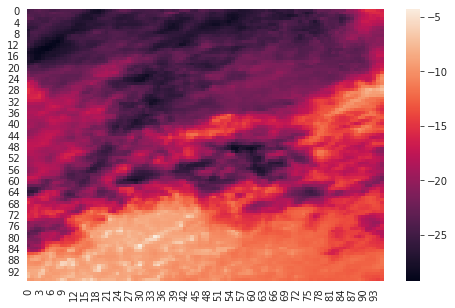

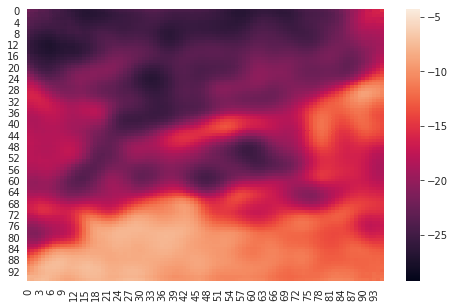

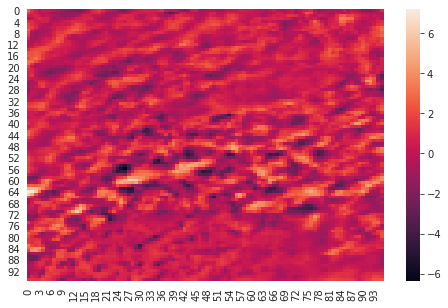

In [31]:
idx = np.random.choice(rx.size(0))
f = valid_dset.inverse_transform(field)[idx, 0]
rf = valid_dset.inverse_transform(rx)[idx, 0]
vmin = f.min()
vmax = f.max()
sns.heatmap(f, vmin=vmin, vmax=vmax)
plt.show()
sns.heatmap(rf, vmin=vmin, vmax=vmax)
plt.show()
sns.heatmap(rf - f)
plt.show()

In [32]:
valid_dset.mu, valid_dset.stdv

(-1.9495956, 19.602049)

In [137]:
rf

array([[0.32440653, 0.26444438, 0.19016162, ..., 0.4955147 , 0.49461085,
        0.4971859 ],
       [0.4068341 , 0.33320954, 0.36923322, ..., 0.49570316, 0.49943432,
        0.49408984],
       [0.36637363, 0.2816208 , 0.22424166, ..., 0.49382597, 0.49398738,
        0.49880618],
       ...,
       [0.4954269 , 0.49353957, 0.49852213, ..., 0.79903185, 0.8348719 ,
        0.71860033],
       [0.49365824, 0.49356836, 0.4978952 , ..., 0.73270774, 0.78359526,
        0.7653764 ],
       [0.49072796, 0.50042474, 0.4962396 , ..., 0.7357389 , 0.83480126,
        0.8094725 ]], dtype=float32)

In [138]:
f

array([[0.3259053 , 0.2674092 , 0.19220017, ..., 0.49559322, 0.49559322,
        0.49559322],
       [0.40389937, 0.3314759 , 0.36490235, ..., 0.49559322, 0.49559322,
        0.49559322],
       [0.3676879 , 0.2813371 , 0.22562659, ..., 0.49559322, 0.49559322,
        0.49559322],
       ...,
       [0.49559322, 0.49559322, 0.49559322, ..., 0.7910864 , 0.8412252 ,
        0.7158773 ],
       [0.49559322, 0.49559322, 0.49559322, ..., 0.73259026, 0.7827296 ,
        0.76044554],
       [0.49559322, 0.49559322, 0.49559322, ..., 0.7298047 , 0.8384401 ,
        0.8189411 ]], dtype=float32)

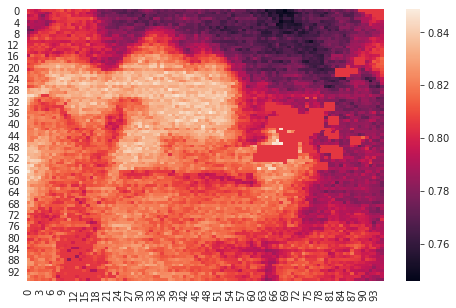

In [52]:
idx = np.random.choice(rx.size(0))
f = field[idx, 0].detach().cpu().numpy()
rf = rx[idx, 0].detach().cpu().numpy()
mask = (f == -1)
fill = np.mean(f[f != -1])
f[mask] = fill
rf[mask] = fill
sns.heatmap(f)

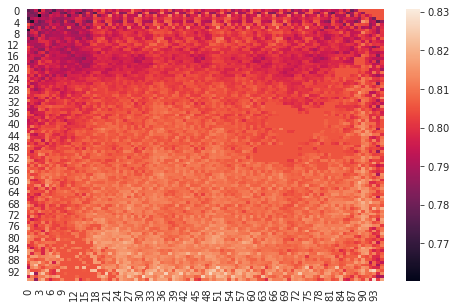

In [53]:
sns.heatmap(rf)

In [25]:
rx.shape

torch.Size([128, 1, 96, 96])

In [36]:
field.shape

torch.Size([128, 9216])

In [37]:
model.parameters()

<generator object Module.parameters at 0x7f55efff8b50>

In [40]:
model.encoder

AttributeError: 'Sequential' object has no attribute 'grad'